In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


bureau = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/bureau_data.csv"
loan = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/loans.csv"
cust = "https://raw.githubusercontent.com/JY6299/CR_Modeling_2/refs/heads/main/customers.csv"

bureau_data = pd.read_csv(bureau)
loan_data = pd.read_csv(loan)
cust_data = pd.read_csv(cust)

bureau_data.shape, loan_data.shape, cust_data.shape

((50000, 8), (50000, 15), (50000, 12))

In [2]:
#By Looking at the Data Structure, First to design the Segmentation

In [3]:
bureau_data.info(), loan_data.info(), cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cust_id                    50000 non-null  object
 1   number_of_open_accounts    50000 non-null  int64 
 2   number_of_closed_accounts  50000 non-null  int64 
 3   total_loan_months          50000 non-null  int64 
 4   delinquent_months          50000 non-null  int64 
 5   total_dpd                  50000 non-null  int64 
 6   enquiry_count              50000 non-null  int64 
 7   credit_utilization_ratio   50000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_id                      50000 non-null  object 
 1   cust

(None, None, None)

In [4]:
#Drop some features that are apparantly meaningless data.
cust_data.drop(columns=['zipcode','state','city'],inplace=True)


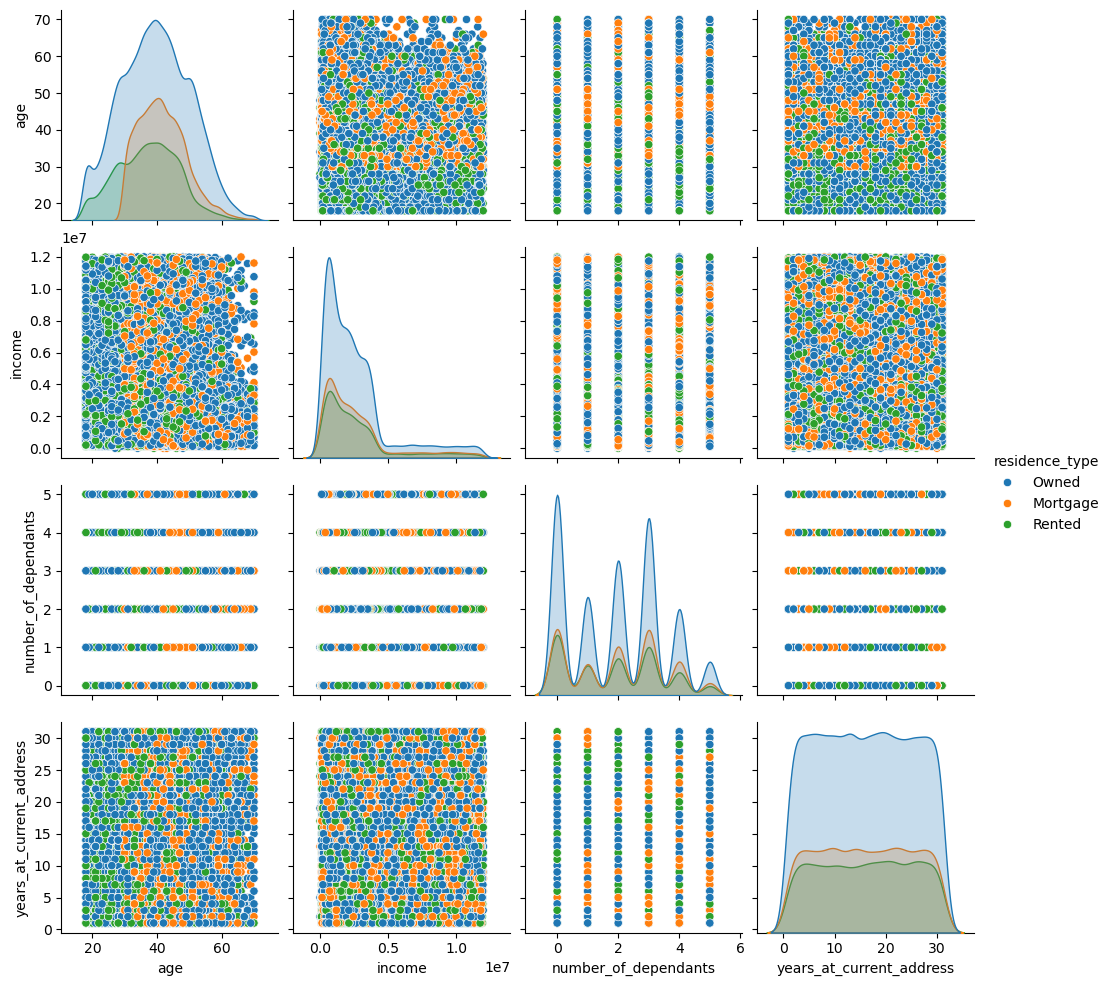

In [5]:
sns.pairplot(cust_data,hue='residence_type') #automatically skip char_var

#theres a significant pattern in age*year_at_current_address: younger people are more likely to rent

In [6]:
# Since we see missing value in residence_type, we fillna by age.
cust_data['residence_type'].value_counts()

cust_data.loc[
    (cust_data['age']<40) & (cust_data['residence_type'].isnull()), 'residence_type'
] = 'Rented'

cust_data.loc[
    (cust_data['age']>=40) & (cust_data['residence_type'].isnull()), 'residence_type'
] = 'Owned'


In [8]:
cust_data['residence_type'].value_counts()

residence_type
Owned       28267
Mortgage    11819
Rented       9914
Name: count, dtype: int64

In [10]:
cust_data.isnull().sum(),loan_data.isnull().sum(),bureau_data.isnull().sum()
#Now all datasets are clean and no missing values

(cust_id                     0
 age                         0
 gender                      0
 marital_status              0
 employment_status           0
 income                      0
 number_of_dependants        0
 residence_type              0
 years_at_current_address    0
 dtype: int64,
 loan_id                        0
 cust_id                        0
 loan_purpose                   0
 loan_type                      0
 sanction_amount                0
 loan_amount                    0
 processing_fee                 0
 gst                            0
 net_disbursement               0
 loan_tenure_months             0
 principal_outstanding          0
 bank_balance_at_application    0
 disbursal_date                 0
 installment_start_dt           0
 default                        0
 dtype: int64,
 cust_id                      0
 number_of_open_accounts      0
 number_of_closed_accounts    0
 total_loan_months            0
 delinquent_months            0
 total_dpd           

In [12]:
#Combine all datasets together based on acct level
df = pd.merge(cust_data,loan_data, how = 'left', on='cust_id')
df = pd.merge(df,bureau_data, how='left', on='cust_id')
df.shape


(50000, 30)

In [ ]:
#### EDA, Explanatory Data Analysis

default
False    0.91406
True     0.08594
Name: proportion, dtype: float64


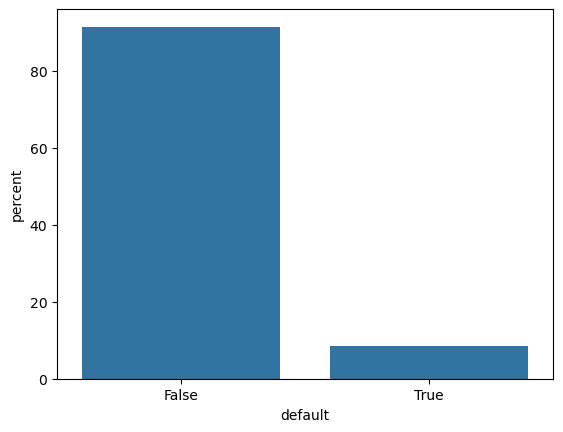

In [19]:
#first take a look at Response Variable, Default.

sns.countplot(data=df, x='default', stat='percent')
print(df['default'].value_counts(normalize=True))
# Default is extremly inbalanced, SMOTE to oversample defaulted(1) population

In [42]:
df[['disbursal_date','installment_start_dt']] = df[['disbursal_date','installment_start_dt']].apply(pd.to_datetime)

num_var = list(df.select_dtypes(include='int64'))
char_var = list(df.select_dtypes(include='object'))

char_var.remove('cust_id'),char_var.remove('loan_id')

for feature in char_var:
    print(f'{feature}: --->{df[feature].unique()}')


gender: --->['M' 'F']
marital_status: --->['Married' 'Single']
employment_status: --->['Self-Employed' 'Salaried']
residence_type: --->['Owned' 'Mortgage' 'Rented']
loan_purpose: --->['Auto' 'Home' 'Personal' 'Education' 'Personaal']
loan_type: --->['Secured' 'Unsecured']


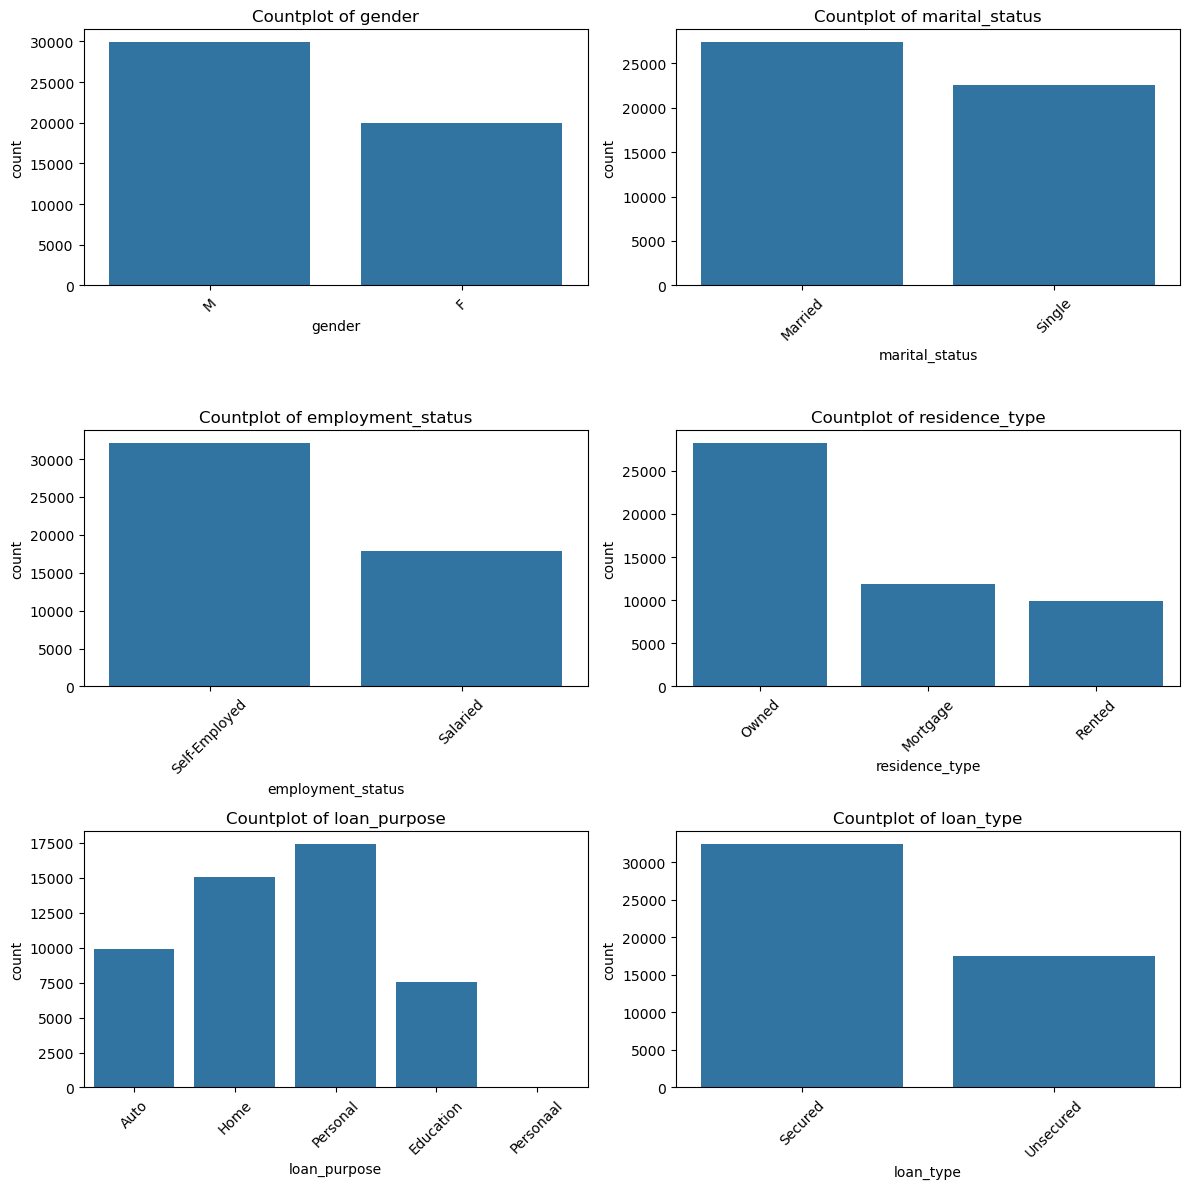

In [48]:
# Countplot for each character variable
n = len(char_var)
ncol = 2 # 2 subgraphs each row
nrow = (n+1) // 2 #round up 

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12,4*nrow))
axes = axes.flatten()

for i, feature in enumerate(char_var):
    sns.countplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Countplot of {feature}')
    axes[i].tick_params(axis='x',rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [49]:
df['loan_purpose'].value_counts()

loan_purpose
Personal     17457
Home         15028
Auto          9936
Education     7557
Personaal       22
Name: count, dtype: int64